In [1]:
%matplotlib inline 
import matplotlib as plt
import numpy as np
import pylab
import pandas as pd
from pandas import read_csv
from random import gauss
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from sklearn.preprocessing import MinMaxScaler
from copy import copy 

In [2]:
wave_data = pd.read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])
wave_data.reset_index(drop=True, inplace=True)
wave_data

,Date,Temp
0,1981.024658,21.8
1,1981.027397,20.0
2,1981.030137,16.2
3,1981.049315,24.8
4,1981.063014,14.4
...,...,...
495,1990.884932,9.9
496,1990.912329,14.7
497,1990.928767,20.5
498,1990.964384,17.2


In [3]:
wave_data=pd.read_csv('discord.csv')
wave_data=wave_data[3500:6500]

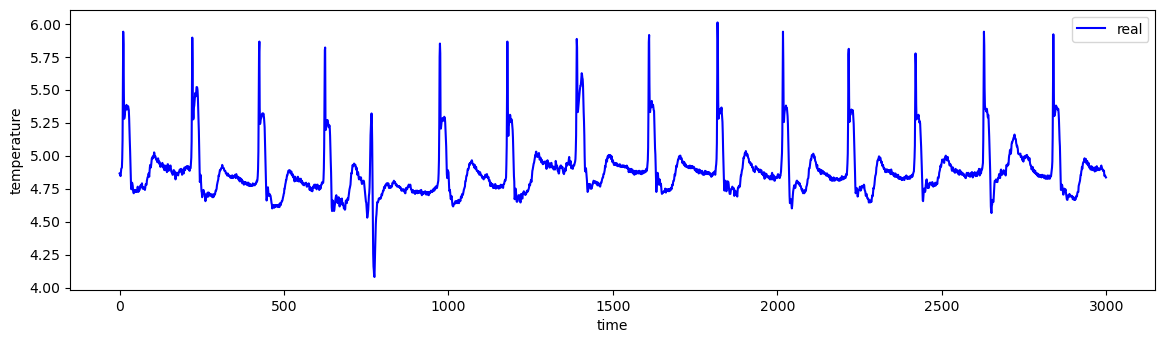

In [4]:
def show_graph(data, label, color="b"):
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.plot(data, color=color, label=label)
    plt.legend(loc='upper right')
    plt.show()
    
X_orig = wave_data["volume"].values
show_graph(X_orig, 'real')

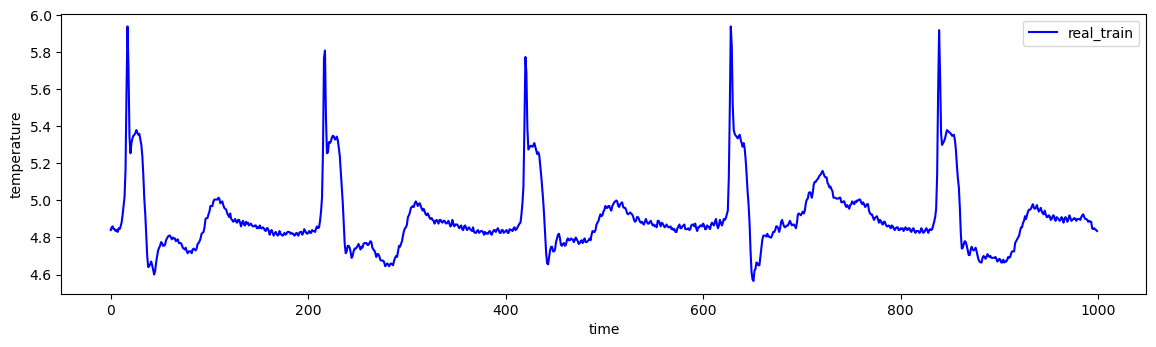

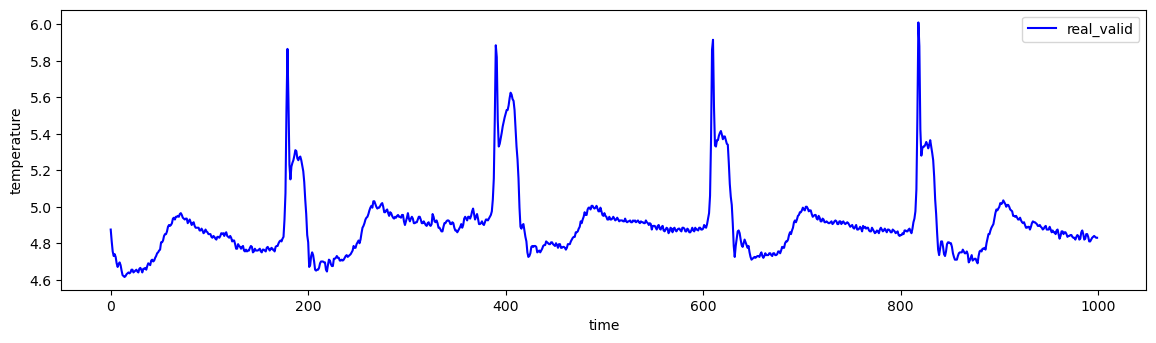

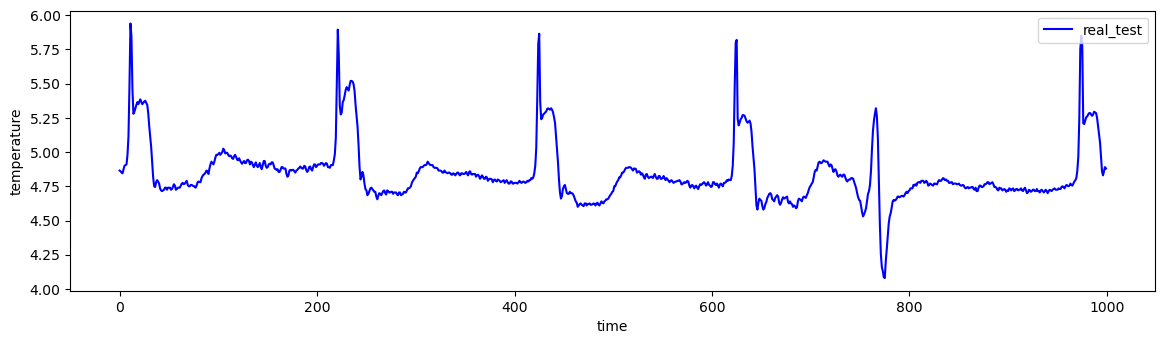

In [5]:
X_train = X_orig[2000:3000]
X_valid = X_orig[1000:2000]
X_test = X_orig[:1000]

show_graph(X_train, 'real_train')
show_graph(X_valid, 'real_valid')
show_graph(X_test, 'real_test')

In [6]:
def get_data(data, time_steps: int=3):
    print('-----get_data-----')
    dataX = []
    print(data.shape)
    for i in range(len(data) - (time_steps - 1)):
        x = data[i:(i + time_steps), :]
        dataX.append(x)
    return np.array(dataX)

def transform_data(original_data: np.array, inverse_option: bool, scaler: object):
    print('-----transform_data-----')
    data_shape = original_data.shape
    data = original_data.reshape(-1, 1)
    if inverse_option is True:
        print('before max {}'.format(max(data)))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data)))
    else:
        print('before max {}'.format(max(data)))
        print('Normalize')
        data = scaler.fit_transform(data)
        print(max(data))
        print('after max {}'.format(max(data)))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps):
    print('-----prepare_data-----')
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler)
    data = np.asarray(data)
    data = data.reshape(-1, 1)
    x = get_data(data, time_steps=time_steps)
    return x, scaler

In [7]:
time_steps = 3
x, scaler = prepare_data(X_train, time_steps)
input_dim = x.shape[-1]
timesteps = x.shape[1]
print('-----return------')
print(x.shape)

-----prepare_data-----
-----transform_data-----
before max [5.94]
Normalize
[1.]
after max [1.]
-----get_data-----
(1000, 1)
-----return------
(998, 3, 1)


In [8]:
def create_model(input_dim,
                 time_steps,
                 latent_dim,
                 # データが一つしかないので1しか選べない
                 batch_size=1,
                 model_option='lstm',
                 optimizer='adam'
                ):
    x = Input(shape=(time_steps, input_dim,))

    if model_option == 'lstm':
        h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
    elif model_option == 'gru':
        h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

    out = Dense(input_dim)(h)

    model = Model(x, out)
    model.summary()

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

model = create_model(input_dim, 
                     time_steps=time_steps,
                     latent_dim=120,
                     model_option='lstm')
model.fit(x, x, epochs=200)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 120)            58560     
                                                                 
 dense (Dense)               (None, 3, 1)              121       
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
32/32 [==============================] - 2s 2ms/step - loss: 0.0356 - mse: 0.0356
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0133 - mse: 0.0133
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 0.0072
Epoch 4/200
32/32 [====================

32/32 [==============================] - 0s 2ms/step - loss: 3.2409e-06 - mse: 3.2409e-06
Epoch 74/200
32/32 [==============================] - 0s 2ms/step - loss: 3.4205e-06 - mse: 3.4205e-06
Epoch 75/200
32/32 [==============================] - 0s 2ms/step - loss: 2.9204e-06 - mse: 2.9204e-06
Epoch 76/200
32/32 [==============================] - 0s 2ms/step - loss: 2.8166e-06 - mse: 2.8166e-06
Epoch 77/200
32/32 [==============================] - 0s 2ms/step - loss: 2.6867e-06 - mse: 2.6867e-06
Epoch 78/200
32/32 [==============================] - 0s 2ms/step - loss: 2.5189e-06 - mse: 2.5189e-06
Epoch 79/200
32/32 [==============================] - 0s 2ms/step - loss: 2.4199e-06 - mse: 2.4199e-06
Epoch 80/200
32/32 [==============================] - 0s 2ms/step - loss: 2.2575e-06 - mse: 2.2575e-06
Epoch 81/200
32/32 [==============================] - 0s 2ms/step - loss: 2.1839e-06 - mse: 2.1839e-06
Epoch 82/200
32/32 [==============================] - 0s 2ms/step - loss: 2.1329e-06 -

32/32 [==============================] - 0s 2ms/step - loss: 2.4749e-08 - mse: 2.4749e-08
Epoch 153/200
32/32 [==============================] - 0s 2ms/step - loss: 2.8392e-08 - mse: 2.8392e-08
Epoch 154/200
32/32 [==============================] - 0s 2ms/step - loss: 2.2382e-08 - mse: 2.2382e-08
Epoch 155/200
32/32 [==============================] - 0s 2ms/step - loss: 3.6251e-08 - mse: 3.6251e-08
Epoch 156/200
32/32 [==============================] - 0s 2ms/step - loss: 2.4675e-08 - mse: 2.4675e-08
Epoch 157/200
32/32 [==============================] - 0s 2ms/step - loss: 3.2213e-08 - mse: 3.2213e-08
Epoch 158/200
32/32 [==============================] - 0s 2ms/step - loss: 1.9739e-08 - mse: 1.9739e-08
Epoch 159/200
32/32 [==============================] - 0s 2ms/step - loss: 2.4211e-08 - mse: 2.4211e-08
Epoch 160/200
32/32 [==============================] - 0s 2ms/step - loss: 2.1838e-08 - mse: 2.1838e-08
Epoch 161/200
32/32 [==============================] - 0s 2ms/step - loss: 6.0

In [16]:
data = pd.read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
data = data.sort_values(by=['Date'])
data.reset_index(drop=True, inplace=True)
data=data['Temp'].values

-----prepare_data-----
-----transform_data-----
before max [26.3]
Normalize
[1.]
after max [1.]
-----get_data-----
(500, 1)
16/16 [==============================] - 0s 997us/step
-----transform_data-----
before max [1.]
Inverse
after max [26.3]
-----transform_data-----
before max [1.0037242]
Inverse
after max [26.400927]


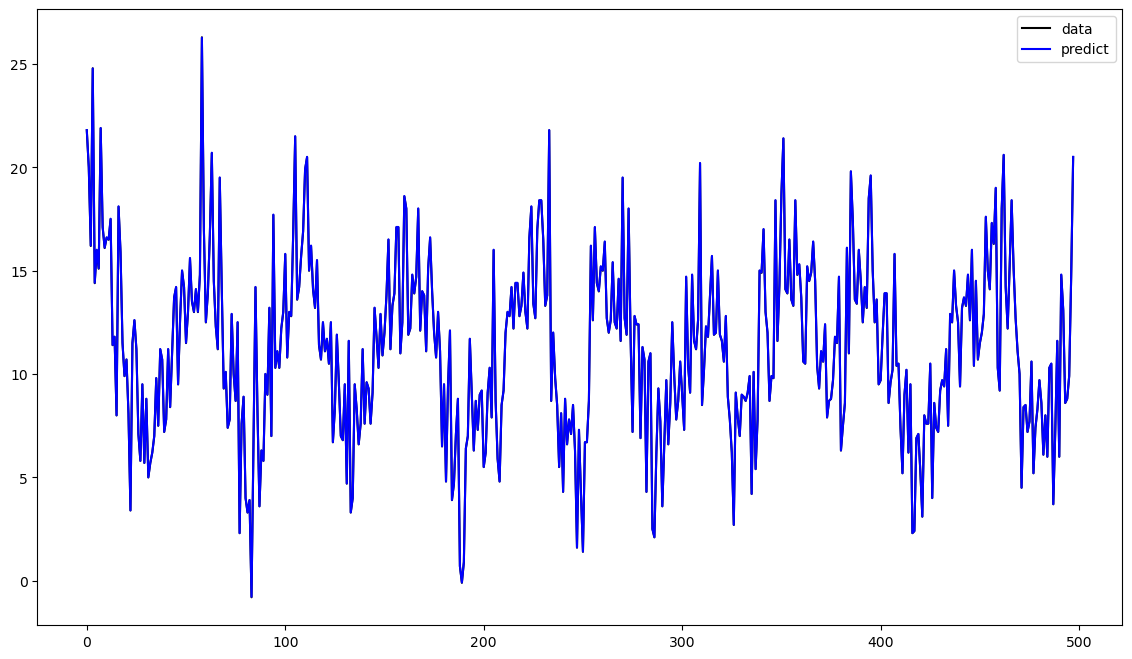

In [18]:
def predict_model_show_graph(x, scaler, model):
    prepare_value = x.copy()
    preds = model.predict(prepare_value)

    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, scaler=scaler)
    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, scaler=scaler)
    
    plt.figure(figsize=(14, 8))
    plt.plot(x_scale[:, 0, 0], color='k', label='data')
    plt.plot(predict_scale[:, 0, 0], color='b', label='predict')
    plt.legend()
    plt.show()
    return predict_scale, x_scale

window = time_steps
x_predict, scaler = prepare_data(data, time_steps)
predict_train, x_scale_train = predict_model_show_graph(x_predict, scaler, model)